In [229]:
import os, string

import pandas as pd
import numpy as np
import itertools
import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.transforms import ScaledTranslation

# TODO:
# * Short the legend following the color code

plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125
plt.rcParams["font.family"]         = "Avenir"

mpl.rcParams['pdf.fonttype'] = 42

mpl.rcParams.update({"pdf.use14corefonts": True})

path_to_scenarios = '/Users/Guille/Desktop/india_power/scenarios'
path_to_images    = '/Users/Guille/Desktop/india_power/images'
path_to_csvs      = '/Users/Guille/Desktop/india_power/gridpath_india_viz/csvs'

In [4]:
scen_labels_ = pd.read_csv(path_to_csvs + '/policy_iced-scenario_labels.csv') 
tech_labels_ = pd.read_csv(path_to_csvs + '/technology_labels.csv') 

In [6]:
# Grab data from databases for plotting energy dispatch and clean energy targets
def _load_transmission(scen_labels_):

    def __load_tx_losses_from_csv(df_, scenario):
        
        df_['transmission_losses_lz_to']   = - df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['transmission_losses_lz_to'] 
        df_['transmission_losses_lz_from'] = - df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['transmission_losses_lz_from']
        df_['transmission_flow_mw']        = df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['transmission_flow_mw']

        df_1_               = df_[['period', 'load_zone_to', 'transmission_losses_lz_to']].copy()
        df_1_['technology'] = 'Tx_Losses'
        df_1_               = df_1_.rename(columns = {'transmission_losses_lz_to': 'power_mw', 
                                                      'load_zone_to': 'load_zone'})

        df_2_               = df_[['period', 'load_zone_from', 'transmission_losses_lz_from']].copy()
        df_2_['technology'] = 'Tx_Losses'
        df_2_               = df_2_.rename(columns = {'transmission_losses_lz_from': 'power_mw',
                                                      'load_zone_from': 'load_zone'})
        
        df_3_ = df_[['period', 'load_zone_to', 'transmission_flow_mw']].copy()
        df_3_ = df_3_.rename(columns = {'transmission_flow_mw': 'power_mw',
                                        'load_zone_to': 'load_zone'})

        df_3_.loc[df_3_['power_mw'] >= 0., 'technology'] = 'Import'
        df_3_.loc[df_3_['power_mw'] < 0., 'technology']  = 'Export'
        
        df_4_ = df_[['period', 'load_zone_from', 'transmission_flow_mw']].copy()
        df_4_ = df_4_.rename(columns = {'transmission_flow_mw': 'power_mw',
                                        'load_zone_from': 'load_zone'})

        df_4_['power_mw'] = - df_4_['power_mw']

        df_4_.loc[df_4_['power_mw'] >= 0., 'technology'] = 'Import'
        df_4_.loc[df_4_['power_mw'] < 0., 'technology']  = 'Export'
        
        df_ = pd.concat([df_1_, df_2_, df_3_, df_4_], axis = 0)
        
        df_ = df_.groupby(['period', 
                           'technology', 
                           'load_zone']).agg({'power_mw': 'sum'}).reset_index(drop = False)

        df_['scenario'] = scenario
        
        return df_

    dfs_ = []
    # Open connection: open database and grab meta-data
    for scen, path in zip(scen_labels_['scenario'], scen_labels_['path']):
        print(scen, path)
        
        dir_name   = r'{}/{}'.format(path, scen)
        tx_losses_ = pd.read_csv(dir_name + f'/results/transmission_timepoint.csv', low_memory = False)
        
        dfs_ += [__load_tx_losses_from_csv(tx_losses_, scen)]

    return pd.concat(dfs_, axis = 0).reset_index(drop = True)



VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_ICEDmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_500GW_ICEDmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_80CAP_500GW_ICEDmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_ICEDmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_100CAP_500GW_ICEDmid /Users/Guille/Desktop/india_power/scenarios/policy
['Export' 'Import' 'Tx_Losses']


In [356]:
def _plot_tranmission_exchange(ax, df_, scen_labels_, 
                               ylabel = 'Electricity Transmission (TWh)',
                               units  = 1e6, 
                               legend = True):

    df_ = df_.groupby(['period', 
                       'scenario',
                       'technology']).agg({'power_mw': 'sum'}).reset_index(drop = False)

    scens_   = df_['scenario'].unique()
    periods_ = df_['period'].unique()

    # techs_, idx_ = np.unique(tech_label_['group'], return_index = True)
    # colors_      = tech_label_.loc[tech_label_.index[idx_], 'group_color'].to_list()
    
    width = 1./(len(scens_) + 1)
    x_    = np.linspace(0, len(periods_) - 1, len(periods_))

    ticks_ = []
    
    for scen, i_scen in zip(scens_, range(len(scens_))):
        color = scen_labels_.loc[scen_labels_['scenario'] == scen, 'color'].to_numpy()[0]
        label = scen_labels_.loc[scen_labels_['scenario'] == scen, 'label'].to_numpy()[0]

        for period, i_period in zip(periods_, range(len(periods_))):
            
            idx_ = (df_['scenario'] == scen) & (df_['period'] == period)
            
            y = np.absolute(df_.loc[idx_ & (df_['technology'] == 'Import'), 'power_mw']).to_numpy()[0]
            z = np.absolute(df_.loc[idx_ & (df_['technology'] == 'Export'), 'power_mw']).to_numpy()[0]            
            
            if i_period == 0:
                ax.bar(x_[i_period], (y + z)/units, width, label = label, 
                                                           color  = color,
                                                             zorder = 2,
                                                             ec     = 'None',
                                                             lw     = 0.,
                                                             aa     = True)
            else:
                ax.bar(x_[i_period], (y + z)/units, width, color  = color,
                                                             zorder = 2,
                                                             ec     = 'None',
                                                             lw     = 0.,
                                                             aa     = True)
            
            ticks_.append(x_[i_period])

        x_ = x_ + .9/len(scens_)

    ticks_ = np.mean(np.array(ticks_).reshape(len(scens_), len(periods_)), axis = 0)

    ax.set_xticks(ticks_, periods_)
    ax.xaxis.set_tick_params(labelsize = 18, left = False)
    ax.set_ylabel(ylabel, fontsize = 18)
    ax.yaxis.set_tick_params(labelsize = 12, left = False)
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    if legend:
        ax.legend(loc            = 'center left',
                  title          = 'Scenarios',
                  title_fontsize = 18,
                  fontsize       = 14,
                  bbox_to_anchor = (1, 0.5),
                  frameon        = False)

    ax.set_ylim(-20.,)

    # ax.set_title(title, fontsize = 20)

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax.grid(axis = 'y')
    
def _plot_transmission_exchange_by_zone(ax, df_, scen_labels_, scen, period,
                                        title    = '',
                                        ylabel   = '',
                                        xlabel   = 'Electricity Transmission (TWh)',
                                        units    = 1e6, 
                                        legend   = True, 
                                        N_states = 30):

    def __robust(df_, zones_, var):
        period    = df_['period'].unique()
        scen      = df_['scenario'].unique()
        zones_p_  = list(df_.loc[df_['technology'] == var, 'load_zone'].to_numpy())
        zones_pp_ = list(set(zones_) ^ set(zones_p_))
        if len(zones_pp_) > 0:
            df_p_ = pd.DataFrame([[period, var, zone, -1e-9, scen] for zone in zones_pp_],
                                 columns = df_.columns)
            df_ = pd.concat([df_, df_p_], axis = 0).reset_index(drop = True)
            return df_.loc[df_['technology'] == var, 'power_mw'].to_numpy()
        else:
            return df_.loc[df_['technology'] == var, 'power_mw'].to_numpy()
        
    scens_   = df_['scenario'].unique()
    periods_ = df_['period'].unique()
    zones_   = df_['load_zone'].unique()

    
    width = 0.8
    x_    = np.linspace(0, N_states - 1, N_states)
             
    idx_ = (df_['scenario'] == scen) & (df_['period'] == period)
    y_   = __robust(df_.loc[idx_], zones_, 'Import')
    z_   = __robust(df_.loc[idx_], zones_, 'Export')
    
    w_ = np.absolute(y_) + np.absolute(z_)
    v_ = np.absolute(y_) - np.absolute(z_)
    idx_ = np.argsort(w_)[-N_states:]

    ax.barh(0., 0., label  = 'Import',
                    align  = 'center',
                    color  = '#2cb4b4',
                    height = width, 
                    zorder = 10)
    
    ax.barh(0., 0., label  = 'Export',
                    color  = '#900C3F',
                    align  = 'center',
                    height = width, 
                    zorder = 10)
    
    ax.barh(0., 0., label  = 'Total',
                    align  = 'center',
                    color  = '#136564',
                    height = width, 
                    zorder = 10)
    
    ax.barh(0., 0., label  = 'Net',
                    color  = '#92918b',
                    align  = 'center',
                    height = width, 
                    zorder = 10)
    
    im_ = ax.barh(x_, y_[idx_]/units,  
                  align  = 'center',
                  color  = '#2cb4b4',
                  height = width, 
                  zorder = 10)
    
    ex_ = ax.barh(x_, z_[idx_]/units,
                  color  = '#900C3F',
                  align  = 'center',
                  height = width, 
                  zorder = 10)
    
    ax.bar_label(container  = ex_, 
                  labels     = [zone.replace("_", " ") for zone in zones_[idx_]], 
                  label_type = "edge", 
                  padding    = 5, 
                  fontsize   = 10)
    
    ttl_ = ax.barh(x_, w_[idx_]/units,
                  color  = '#136564',
                  align  = 'center',
                  height = width/2., 
                  zorder = 10)
    
    net_ = ax.barh(x_, v_[idx_]/units,
                   color  = '#92918b',
                   align  = 'center',
                   height = width/2., 
                   zorder = 10)
        
    ax.set_yticks([], [])
    ax.set_xlabel(xlabel, fontsize = 14)
    ax.set_ylabel(ylabel, fontsize = 14, labelpad = 30.)
    

    ax.xaxis.set_tick_params(labelsize = 12, left = False)
    ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.axvline(0, linewidth = .5, 
                  linestyle = '-', 
                  color     = 'k', 
                  clip_on   = False, 
                  zorder    = 10)

    if legend:
        ax.legend(loc      = 'lower right',
                  fontsize = 12,
                  frameon  = False)

    #ax.set_xlim(-600., 600)
    ax.set_ylim(-1, len(zones_[idx_]))

    ax.set_title(title, fontsize = 16)

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax.grid(axis = 'x')

# Transmission Exchange

In [ ]:
transmission_ = _load_transmission(scen_labels_)

### System Level

VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_ICEDmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_500GW_ICEDmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_80CAP_500GW_ICEDmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_ICEDmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_100CAP_500GW_ICEDmid /Users/Guille/Desktop/india_power/scenarios/policy


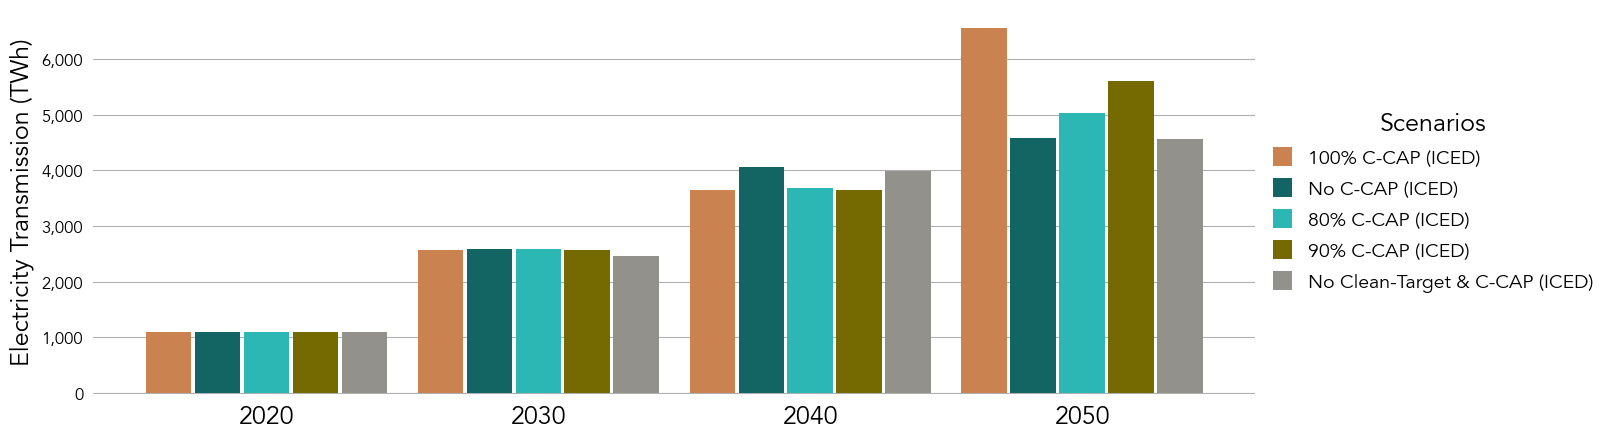

In [225]:
fig = plt.figure(figsize = (15, 5))
_ax = plt.subplot(111)

_plot_tranmission_exchange(_ax, transmission_, scen_labels_)

plt.savefig(path_to_images + r'/system_level-tranmission_exchange.png', 
            bbox_inches = 'tight', 
            dpi         = 600)

plt.show()

### Zone Level

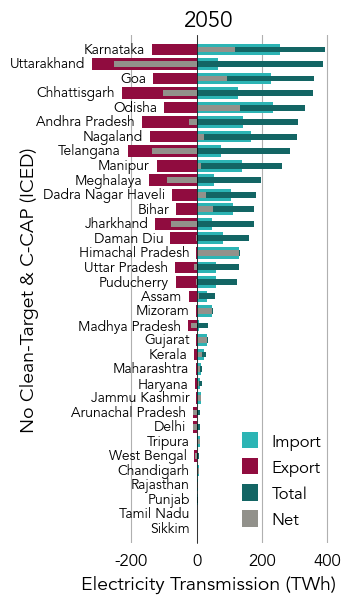

In [360]:
scen = 'VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_ICEDmid'
period = 2050

label = scen_labels_.loc[scen_labels_['scenario'] == scen, 'label'].to_numpy()[0]
    
fig = plt.figure(figsize = (3.3, 6.6))
_ax = plt.subplot(111)

_plot_transmission_exchange_by_zone(_ax, transmission_, scen_labels_, scen, period, 
                                    title  = f'{period}',
                                    ylabel = f'{label}', 
                                    xlabel = 'Electricity Transmission (TWh)',
                                    N_states = 34)


plt.savefig(path_to_images + r'/zone_level-transmission_exchange.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

# Mosaic

In [353]:
transmission_ = _load_transmission(scen_labels_)

VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_ICEDmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_500GW_ICEDmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_80CAP_500GW_ICEDmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_ICEDmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_100CAP_500GW_ICEDmid /Users/Guille/Desktop/india_power/scenarios/policy
['VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_ICEDmid'
 'VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_500GW_ICEDmid'
 'VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_80CAP_500GW_ICEDmid'
 'VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_ICEDmid'
 'VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_100CAP_500GW_ICEDmid']
[2020 2030 2040 2050]


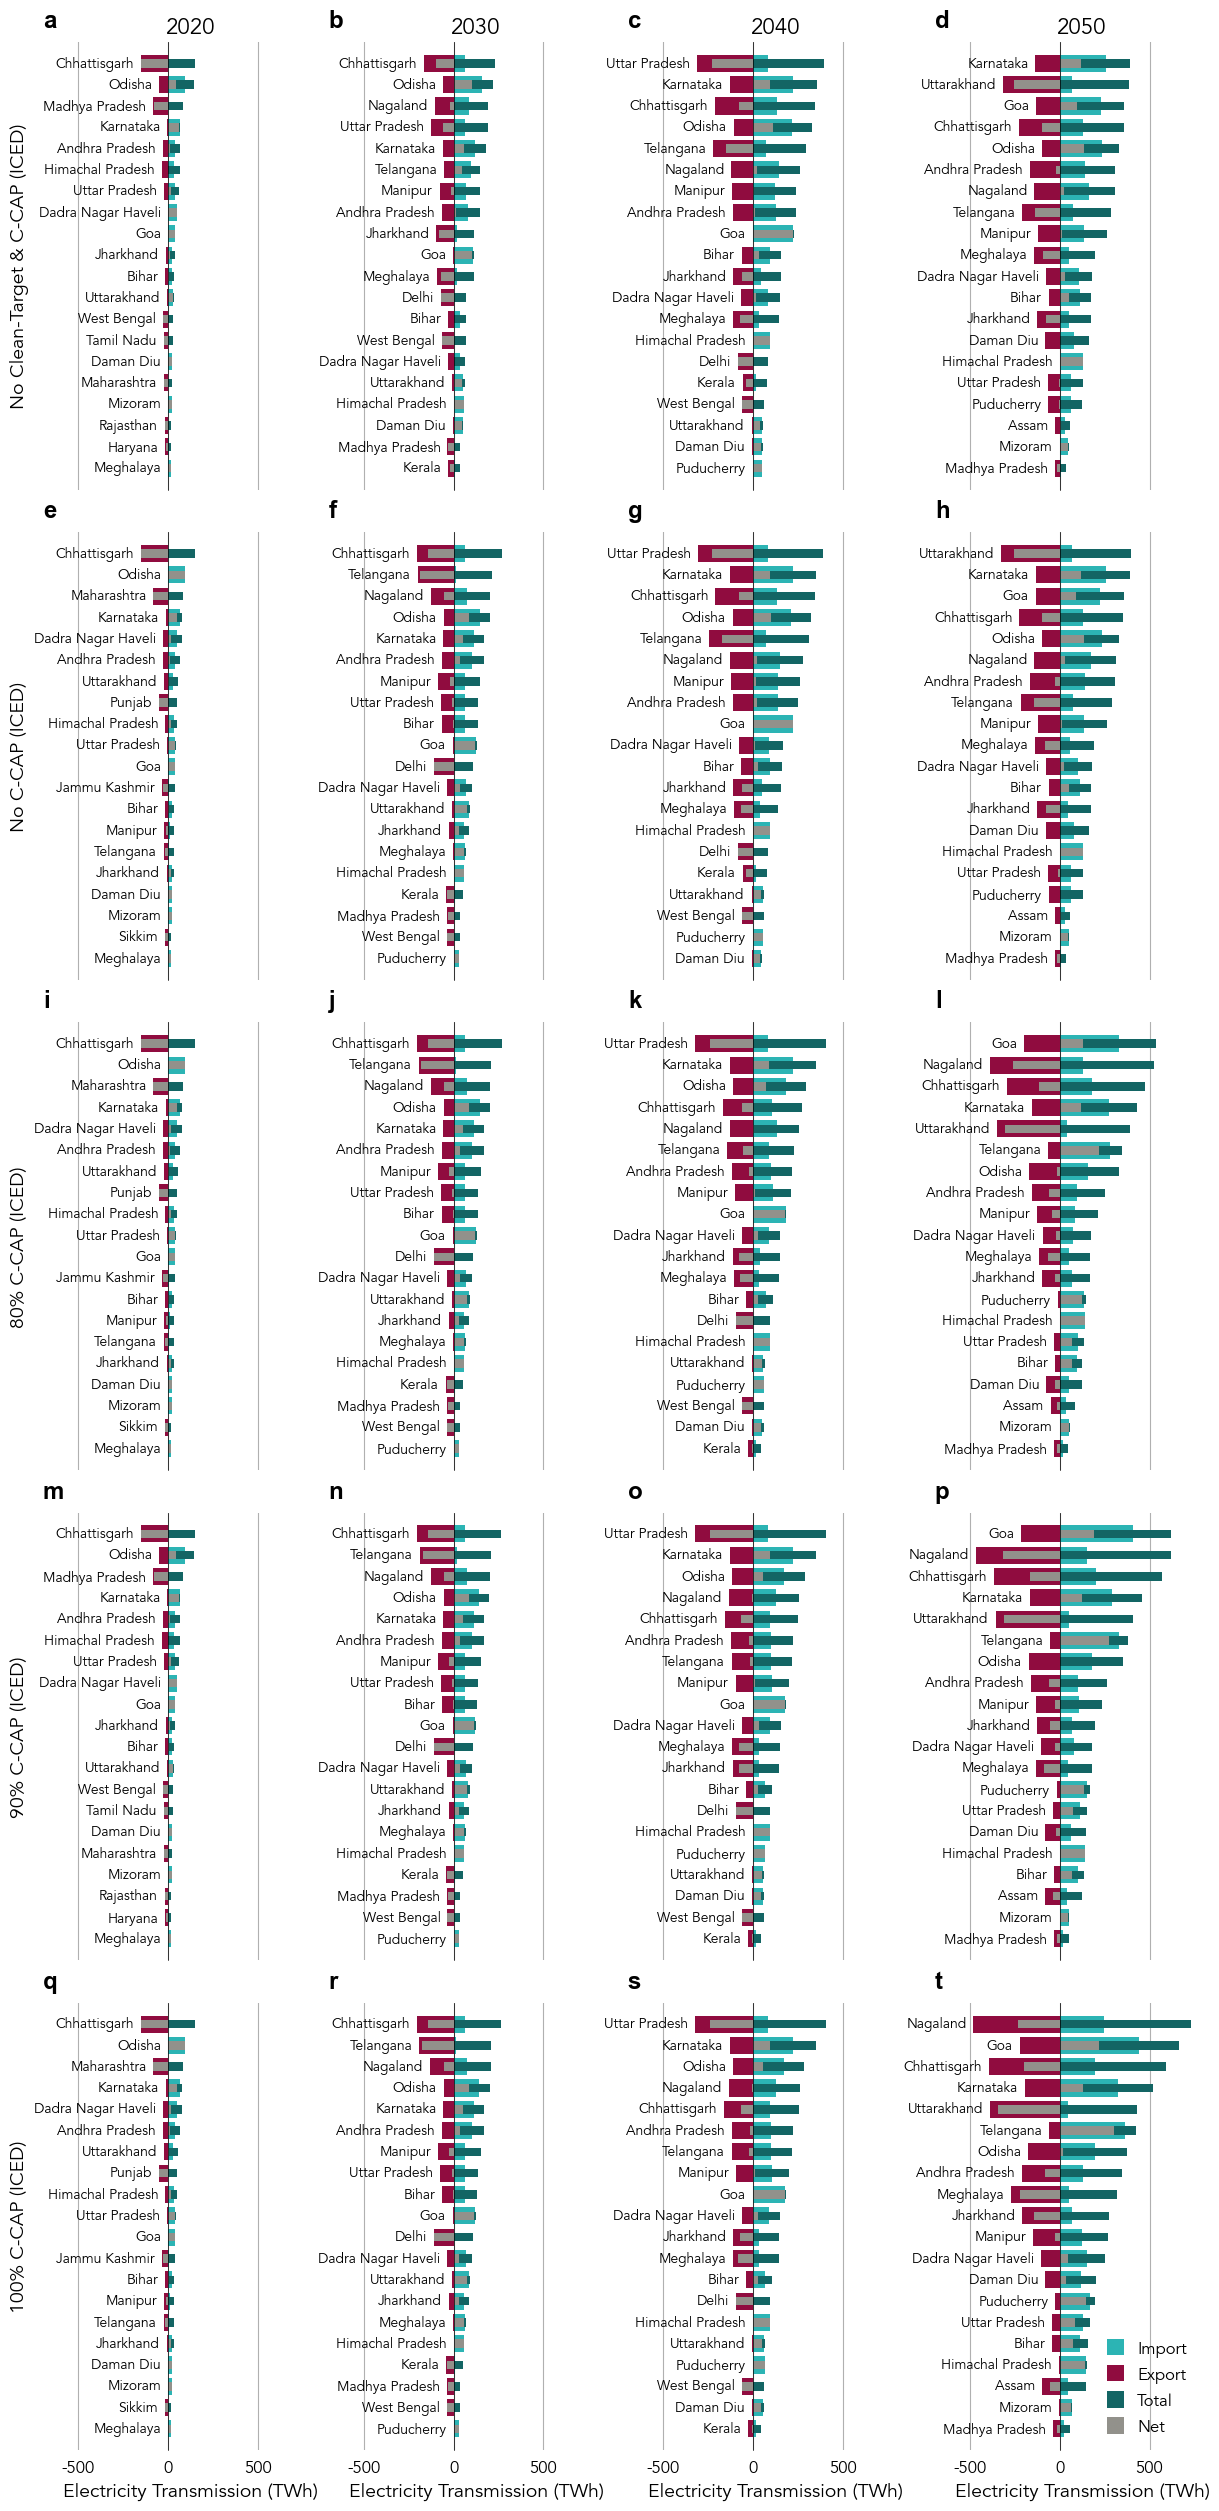

In [362]:
scens_   = transmission_['scenario'].unique()
periods_ = transmission_['period'].unique()
letters_ = [list(string.ascii_lowercase)[i*len(periods_):i*len(periods_) + len(periods_)] 
            for i in range(len(scens_))]

fig, _ax = plt.subplot_mosaic(letters_, layout      = 'constrained', 
                                        sharey      = True,
                                        sharex      = True,
                                        figsize     = (.75*len(letters_[0])*len(periods_), 5*len(letters_)), 
                                        gridspec_kw = {'width_ratios': [1]*len(letters_[0])})

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
                             fontsize  = 'xx-large', 
                             weight    = "bold",
                             va        = 'bottom',
                             family    = 'Arial')

    
    
n      = len(letters_)*len(letters_[0])
k      = 1
legend = False

for i in range(len(letters_)):
    for j in range(len(letters_[i])):
        
        scen   = scens_[i]
        period = int(periods_[j])
        label  = scen_labels_.loc[scen_labels_['scenario'] == scen, 'label'].to_numpy()[0]

        if i == 0:
            title = f'{period}'
        else:
            title = ''
        
        if j == 0: 
            ylabel = label
        else: 
            ylabel = ''
            
        if i == len(letters_) - 1: 
            xlabel = 'Electricity Transmission (TWh)'
        else: 
            xlabel = ''
                    
        if k == n: 
            legend = True
        else:
            k += 1
            
        _plot_transmission_exchange_by_zone(_ax[letters_[i][j]], transmission_.copy(), 
                                            scen_labels_, scen, period, 
                                            title    = title, 
                                            ylabel   = ylabel, 
                                            xlabel   = xlabel,
                                            legend   = legend, 
                                            N_states = 20)

plt.savefig(path_to_images + r'/zone_level-transmission_exchange.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()